Scattering Options:
                            Type : xray
                  Default Energy : 17.000 keV
                    Powder Units : tth
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
                   Sample Offset :  0.00
             Minimum Theta angle : -180.00
             Maximum Theta angle : 180.00
         Minimum Two-Theta angle : -180.00
         Maximum Two-Theta angle : 180.00
density = 4.620 gm/cm$^3$


AttributeError: 'types.SimpleNamespace' object has no attribute 'E0_entrance'

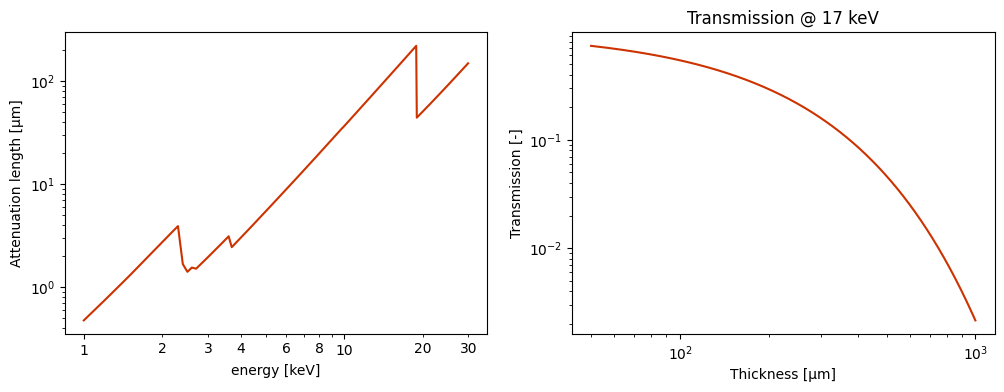

In [49]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np

# load standard parameters
params = {}
params['BEAM'] = {}
params['GEOMETRY'] ={}
params['BEAM']['transverse_width'] = 100

params['GEOMETRY']['hkl'] = np.array([2,0,0]) #'3, 3, 3'

params['BEAM']['lmbd'] = 7.2932e-5 #7.2932e-11 m = 17 keV
params['GEOMETRY']['shape'] = np.array([300, 300, 10]) #[16000, 1600, 2000]
shape_µm = np.array([4000,4000,150])
params['GEOMETRY']['del_x'] = shape_µm/params['GEOMETRY']['shape']#'0.05, 0.05, 0.05'
params['BEAM']['mid'] = np.array([0.5, 0.5]) # axis 0, axis 1


cif_file='KNO 2310011.cif'
''' get scatter function based on dan's diffraction
    Dan's diffraction reads cif files and is used to calculate correct atomic positions for scattering
    Dan's diffraction does not include a function for anomalous scattering, but this has been made based on xrddb and is assigned separately
'''

import Dans_Diffraction


xtl = Dans_Diffraction.Crystal(cif_file)
xtl.generate_lattice()
wavelength_in_um = float(params['BEAM']['lmbd'])
wavelength = wavelength_in_um*10**-6 # in meters
energy_kev = 4.135667696*10**-15 *299792458 / wavelength /1000 # h[eV⋅s]*c[m⋅s]/wavelength[m]
xtl.Scatter.setup_scatter(type='xray', energy_kev=energy_kev)


########################## crystal rotation functions #####################
def rotate(x,z,phi):# 2D rotation function 
    '''
    generic rotation funciton for generating the crystal rotation function 
    '''
    return x*np.cos(phi)-z*np.sin(phi),z*np.cos(phi)+x*np.sin(phi)
def rotate_x(loc,phi):#rotate_x: rotates around x axis (horisontal)
    '''
    in-place rotation around x axis for generating the crystal rotation function 
    '''
    x,z=rotate(loc[1],loc[2],phi)
    loc[1] = x
    loc[2] = z
def rotate_y(loc,phi):# rotate_y: rotates around y axis (vertical)
    '''
    in-place rotation around y axis for generating the crystal rotation function 
    '''
    x,z=rotate(loc[0],loc[2],phi)
    loc[0] = x
    loc[2] = z
def rotate_z(loc,phi):#rotate_z: rotates around z axis (out-of-plane)
    '''
    in-place rotation around z axis for generating the crystal rotation function 
    '''
    x,z=rotate(loc[0],loc[1],phi)
    loc[0] = x
    loc[1] = z
#f1f2_BrennanCowan = pkg_resources.read_text(databases, 'f1f2_BrennanCowan.dat')

def crystal_rotation_function(hkl):
    '''
    function that describes rotation in cartesian coordinates of crystal structure or reciprocal space
    performes an in-place rotation on a numpy array of length three
    '''
    rotate_x(hkl, np.pi/2)# 45 degree rotation around the x-axis -> swap b and c
    return hkl

hkl = params['GEOMETRY']['hkl']
Q = xtl.Cell.calculateQ(hkl)[0]
Q = crystal_rotation_function(Q)*10**4 # in inverse um
params['BEAM']['Q_vector'] =  Q



import importlib
import draw_crystal_structures
importlib.reload(sys.modules['draw_crystal_structures'])
def make_crystal_structure():
        return draw_crystal_structures.add_crystal_structure( cif_file, scale = 6.0, 
                                        rotation_function = crystal_rotation_function, 
                                        legend_pos_shift = [0,0,-50],
                                        axes_shift = [-5,0,3],
                                        #make_bonds=['O','O'],
                                        max_bond_length = 1.5, min_bond_length = 0,
                                        linewidth = 3,
                                        bounding_box_facecolor = [0.5,0.6,0.7,0],
                                        cage_line_color = [0.8,0.8,0.8,1],
                                        linecolor = [0.5,0.5,0.5,1])
# import the renderer
import three_d_draw
import three_d_draw_object_classes
import importlib
importlib.reload(sys.modules['three_d_draw_object_classes'])
importlib.reload(sys.modules['three_d_draw'])
# what we want is a blender backend. Unfortunately blender does not install easily as a module (without gui). 
# Therefore use mayavi for 3d rendering (slow) or matplotlib for pseudo-3d rendering(fast)
backend = 'plotly' # default is 'matplotlib'
#backend = 'matplotlib'
three_d_draw.set_backend(backend)
#dfxrm.three_d_draw.timing=True # <- enable this if you want to time the rendering

fig, axes = plt.subplots(1,2,figsize=(12,4), dpi=100)

ax = axes[0]
energies = np.arange(1,30,0.1)
#absorption_invum = xtl.Properties.absorption(energy_kev=energies) #Returns the sample absorption coefficient in um^-1 at the requested energy in keV
attenuation_um = xtl.Properties.xray_attenuation_length(energy_kev=energies)*10 # the *10 == bug in dan's diffraction? 
ax.loglog(energies, attenuation_um, color = [0.8,0.2,0])
ax.set_xlabel('energy [keV]')
ax.set_ylabel(r'Attenuation length [µm]')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,20,30], minor = True)
ax.set_xticklabels([1,2,3,4,'',6,'',8,'',10,20,30], minor = True)
ax.set_xticks([1,10])
ax.set_xticklabels([1,10])

ax = axes[1]
thickness = np.arange(50,1000,1)
#absorption_invum = xtl.Properties.absorption(energy_kev=energies) #Returns the sample absorption coefficient in um^-1 at the requested energy in keV
att = xtl.Properties.xray_attenuation_length(energy_kev= xtl.Scatter._energy_kev)[0]*10
xray_transmission = np.exp(-thickness/att)
ax.loglog(thickness, xray_transmission, color = [0.8,0.2,0])
ax.set_xlabel('Thickness [µm]')
ax.set_ylabel(r'Transmission [-]')
ax.set_title(f'Transmission @ {np.round(xtl.Scatter._energy_kev):.0f} keV')
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10,20,30], minor = True)
#ax.set_xticklabels([1,2,3,4,'',6,'',8,'',10,20,30], minor = True)
#ax.set_xticks([1,10])
#ax.set_xticklabels([1,10])

print(f'density = {xtl.Properties.density():.3f} gm/cm'+r'$^3$')

def final_rotation_function(drawing):
    #drawing.rot_y(-10*np.pi/180) # z in coordinate system of drawing is out of plane
    #drawing.rot_x(10*np.pi/180) # z in coordinate system of drawing is out of plane
    return

import types
ex = types.SimpleNamespace()
ex.params = params
ex.Q_vector = params['BEAM']['Q_vector'] # in inverse µm
ex.shape = params['GEOMETRY']['shape']
ex.del_x = params['GEOMETRY']['del_x']
if 1:
    '''
    Calculate self.k0_vector and self.kh_vector so that they lie in the plane defined by self.Q_vector and the [001] axis
    input: None
    Return: None
    '''
    lmbd = float(params['BEAM']['lmbd'])
    k = 2*np.pi/lmbd
    Q = np.linalg.norm(ex.Q_vector)
    plane_normal = np.cross(ex.Q_vector,np.array([0,0,1]))
    k_dir_orthogonal_to_Q = np.cross(plane_normal,ex.Q_vector)
    k_ort_l = np.linalg.norm(k_dir_orthogonal_to_Q)
    '''
    We have:
        k0 = -0.5*Q + x*k_ort
        so that |k0| = k
        where Q and k_ort are orthogonal, so that
        0.25|Q|**2 + x**2*|k_ort|**2 = |k0|**2
        i.e:
        x = np.sqrt(  ( |k0|**2 - 0.25|Q|**2 ) / ( |k_ort|**2) )
    '''
    x = np.sqrt(  ( k**2 - 0.25*Q**2 ) / ( k_ort_l**2) )
    ex.k0_vector = -0.5*ex.Q_vector + x*k_dir_orthogonal_to_Q
    ex.kh_vector = 0.5*ex.Q_vector + x*k_dir_orthogonal_to_Q

beam_plan_normal = np.cross(ex.k0_vector,np.cross(ex.k0_vector,ex.Q_vector))



if 1:
    drawing, fig, ax, = three_d_draw.make_3d_perspective(ex, #volume_data = make_internals(step_size = 1),
                                                                            scale = 0.1/8,
                                                                            beam_step_size = 1, show_beam_at_end = False, 
                                                                            view_angle=20, fig_size = (12,6), factor = 350,
                                                                            tilt_to_vector = beam_plan_normal,
                                                                            extend_imaging_system = (10,50),
                                                                            imaging_system_lw = 0,
                                                                            extend_beam = [30,30],
                                                                            draw_axes = True,
                                                                            draw_curved_arrows = False,
                                                                            #beam_draw_mesh = False,
                                                                            #draw_face_axes = True,
                                                                            crystal_rotation_function = crystal_rotation_function,
                                                                            beam_opacity= 1.0,
                                                                            #export_blender_filepath = 'pickle_to_blender.pickled',
                                                                            atom_list = make_crystal_structure(),
                                                                            #lens_scale = 0.5,
                                                                            final_rotation_function= final_rotation_function,
                                                                            bounding_box_facecolor = [0,0,0,0.3],
                                                               )#(600*4, 300*4))
    fig.show()
    if backend == 'mayavi':
        import mayavi.mlab, IPython.display
        mayavi.mlab.savefig('example.png')
        mayavi.mlab.close(fig)
        display(IPython.display.Image(filename='example.png', width=600))

xtl.Scatter._scattering_max_twotheta = 45
reflections = xtl.Scatter.print_all_reflections().split('\n')
print(reflections[0])
print(reflections[2]+'  d_spacing [Å]')
for reflection in reflections[3:-2]:
    spli = reflection.split()
    #lambda = 2dsin(theta)
    d_spacing = params['BEAM']['lmbd']*10**4/(2*np.sin(np.pi/360*float(spli[-2])))
    print(reflection+f'  {d_spacing:13.3f}')



In [47]:
print(xtl.cif['_chemical_formula_sum'])

K Nb O3
